In [1]:
import os
import sys

import random
import warnings
import time
import pprint as pp
from keras import layers
from keras import models
from time import strftime, gmtime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython import get_ipython

ip = get_ipython()

if ip == None:
    print('Python Script from notebook is running.')
    plt.switch_backend('agg')
else:
    print('Notebook is running.')

Notebook is running.


In [3]:
import os

from os import walk
import copy

scratch_dir = '/scratch/gilbreth/azehady/'
project_dir = 'automatic_fossil_image_detection/' 

os.chdir(scratch_dir + project_dir)

path = scratch_dir + project_dir + 'datapack_images/Global/Foram_TSCLite_Images'

file_names = None
for (dirpath, dirnames, fnames) in walk(path):
    file_names = fnames

single_image_file = []
multiple_image_file = []
genus_single = []
species_single = []
genus_multiple = []
species_multiple = []

for f in file_names:
    forig = copy.copy(f)
    if ' ' in f:
        f = f.split(' ')
    elif '_' in f:
        f = f.split('_')
    if 'tiny' in forig and len(f) != 2:
        #print('single = ' + str(f))
        single_image_file.append(forig)
        genus_single.append(f[0])
        species_single.append(f[1])
    else:
        #print('multi = ' + str(f))
        multiple_image_file.append(forig)
        genus_multiple.append(f[0])
        fm = f[1].split('.')[0]
        species_multiple.append(fm)

        
        
'''

print(genus_single)
print(species_single)
print('')
print(genus_multiple)
print(species_multiple)

'''


for i, f in enumerate(single_image_file):
    s = str(genus_single[i]) + ', ' + str(f)
    #print(s)
    
#print(len(genus_single))
#print(genus_multiple)

In [4]:
# multi_cls: Dict keyed by the unique genus name and for each genus name the index of the image file from 236 files
# final_cls: Dict keyed by the unique genus names, values indicate the index of the first image file with the same genus

# classes: Dict gives the unique genus/class id for 236 genus files, keyed from 0 to 236 (236 image files)
# class_names: Dict gives the unique genus/class id for 236 genus files, keyed by the unique genus name
# uniq_cls: list gives the unique genus names

# 79 different classes
cls = genus_single
file_names = single_image_file
multi_cls = {}
final_cls = {}
k = 0
for j, cl in enumerate(cls):
    if cl in multi_cls.keys():
        multi_cls[cl].append(j)
    else:
        a = [j]
        multi_cls[cl] = a
        final_cls[cl] = k
        k += 1
    
print(multi_cls)
print("")
print(final_cls)
print("")

classes = {}
class_names = {}
for k in multi_cls.keys():
    clss = multi_cls[k]
    for c in clss:
        classes[c] = final_cls[k]
        class_names[c] = k
     
print(classes)
print("")
print(class_names)

uniq_cls = uniq_genus = list(multi_cls.keys())

print("")
print(uniq_cls)
        
#print(cls)
#print(file_names)

{'Globorotalia': [0, 4, 5, 15, 35, 42, 51, 54, 74, 78, 103, 111, 117, 124, 127, 138, 141, 145, 147, 148, 157, 160, 170, 180, 186, 190, 214, 227, 234], 'Hedbergella': [1, 188], 'Globigerinoides': [2, 11, 23, 45, 80, 106, 125, 140, 181, 203, 219, 226], 'Cribrohantkenina': [3], 'Globoturborotalita': [6, 43, 152, 156, 182], 'Globigerina': [7, 33, 52, 53, 98, 101, 107, 194, 211], 'Morozovella': [8, 14, 47, 61, 66, 70, 76, 77, 130, 137, 164, 193], 'Acarinina': [9, 25, 26, 37, 40, 83, 95, 121, 132, 206, 216, 224], 'Thalmanninella': [10, 69], 'Tenuitella': [12, 30, 213], 'Sigalia': [13], 'Praemurica': [16, 126], 'Planorotalites': [17], 'Clavatorella': [18], 'Turborotalia': [19, 20, 116, 179, 207, 223], 'Globotruncana': [21, 86, 142, 225], 'Microhedbergella': [22, 129, 189], 'Ventilabrella': [24], 'Pseudoguembelina': [27, 96, 165, 204], 'Pseudohastigerina': [28, 200, 228], 'Globanomalina': [29, 110, 201, 218], 'Whiteinella': [31, 104, 108, 109], 'Pseudothalmanninella': [32, 123], 'Pulleniatina'

In [5]:
# Link: https://gist.github.com/oeway/2e3b989e0343f0884388ed7ed82eb3b0

import numpy as np
import scipy
import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
import collections
from PIL import Image
import numbers
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util


def center_crop(x, center_crop_size):
    assert x.ndim == 2
    centerw, centerh = x.shape[0] // 2, x.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    return x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh]

def center_crop_rgb(x, center_crop_size):
    assert x.ndim == 3
    centerw, centerh = int(x.shape[0] // 2), int(x.shape[1] // 2)
    halfw, halfh = int(center_crop_size[0] // 2), int(center_crop_size[1] // 2)
    
    chan = x.shape[2]
    xr = np.zeros((int(center_crop_size[0]), int(center_crop_size[1]), chan))
    
    for c in range(chan):
        xr[0:int(center_crop_size[0]), 0:int(center_crop_size[1]), c] = x[centerw - halfw:centerw + halfw, centerh - halfh:centerh + halfh, c]
        
    return xr

def rotate(image_array: ndarray, degree):
    return sk.transform.rotate(image_array, degree)

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    return np.flipud(image_array)


In [6]:
# Load image data from file
# And augment images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import cv2 as cv

img_width = 331 #128 * 2 * 2
img_height = 331 #128 * 2 * 2
img_chan = 3

#plt.figure(figsize=(20,10))
train_imgs = []
train_lbls = []
for j, fname in enumerate(file_names):
    img = load_img(path + '/' + fname)
    # converting to numpy array
    imga = np.array(img)
    
    # reshaping to same size using the power of cv
    imgr = cv.resize(imga, (img_width, img_height), interpolation=cv.INTER_AREA)
    #print(imgr.shape)
    train_imgs.append(imgr)
    clas = final_cls[class_names[j]]
    train_lbls.append(clas)
    
    #plt.subplot((j%10) + 1,len(file_names), (j%10) + 1)
    print(j)
    print(class_names[j])
    #plt.imshow(train_imgs[j])

    #plt.show()

train_lbls = to_categorical(train_lbls)


0
Globorotalia
1
Hedbergella
2
Globigerinoides
3
Cribrohantkenina
4
Globorotalia
5
Globorotalia
6
Globoturborotalita
7
Globigerina
8
Morozovella
9
Acarinina
10
Thalmanninella
11
Globigerinoides
12
Tenuitella
13
Sigalia
14
Morozovella
15
Globorotalia
16
Praemurica
17
Planorotalites
18
Clavatorella
19
Turborotalia
20
Turborotalia
21
Globotruncana
22
Microhedbergella
23
Globigerinoides
24
Ventilabrella
25
Acarinina
26
Acarinina
27
Pseudoguembelina
28
Pseudohastigerina
29
Globanomalina
30
Tenuitella
31
Whiteinella
32
Pseudothalmanninella
33
Globigerina
34
Pulleniatina
35
Globorotalia
36
Parasubbotina
37
Acarinina
38
Praeorbulina
39
Cassigerinella
40
Acarinina
41
Astrorotalia
42
Globorotalia
43
Globoturborotalita
44
Globuligerina
45
Globigerinoides
46
Hantkenina
47
Morozovella
48
Helvetoglobotruncana
49
Planoglobulina
50
Planulina
51
Globorotalia
52
Globigerina
53
Globigerina
54
Globorotalia
55
Globigerinelloides
56
Globigerinelloides
57
Globuligerina
58
Globigerinatheka
59
Globuligerina
60

In [7]:
# Image Data Augmentation
from copy import copy


nrow = 3
ncol = 13

#f, ax = plt.subplots(nrow, ncol, figsize=(20, 20))
aug_images = []
aug_labels = []
for j, img in enumerate(train_imgs):
    #ax[j][0].imshow(img)
    
    #center crop
    crop_size = (3*img_width/4, 3 * img_height/4, img_chan)
    img_cc = copy(center_crop_rgb(img, crop_size))
    #aug_images.append(img_cc)
    #aug_labels.append(train_lbls[j])
    
    #ax[j][1].imshow(img_cc)
    
    # horizontal flip
    img_hf = horizontal_flip(img)
    aug_images.append(img_hf)
    aug_labels.append(train_lbls[j])
    #ax[j][2].imshow(img_hf)
    
    
    # vertical flip
    img_ud = vertical_flip(img)
    aug_images.append(img_ud)
    aug_labels.append(train_lbls[j])
    #ax[j][3].imshow(img_ud)
    
    # random rotation
    k=0
    for angle in range(15, 360, 45): # 8 different angles
        img_rr= copy(rotate(img, angle))
        aug_images.append(img_rr)
        aug_labels.append(train_lbls[j])
        #ax[j][4 + k].imshow(img_rr)
        k += 1
    #print(k)
    
    # random noise
    img_rn= random_noise(img)
    aug_images.append(img_rn)
    aug_labels.append(train_lbls[j])
    #ax[j][4 + k].imshow(img_rn)

aug_labels = np.array(aug_labels)
#plt.show()

In [8]:
# get the main training image data
train_images = np.array(train_imgs)
# For Dense layers
#train_images = train_images.reshape(len(train_images), img_width * img_height * img_chan)
# For CNN
train_images = train_images.reshape(len(train_images), img_width, img_height, img_chan)
train_images = train_images.astype('float32') / 255

# convert into categorical y label
train_labels = np.array(train_lbls)


In [9]:
print(train_images.shape)
print(train_labels.shape)

(236, 331, 331, 3)
(236, 79)


In [10]:
def categorical_to_cls(train_label):
    for ix,x in enumerate(train_label):
        if x != 0:
            break
    
    return(ix)

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
7
Globigerina


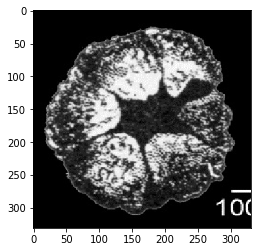

In [11]:
# Randomly select a training image and check the correctness of the genus class

ir = np.random.randint(0, train_labels.shape[0])

print(train_labels[ir])
cl = categorical_to_cls(train_labels[ir])
print(cl)
print(class_names[cl])
plt.imshow(train_images[ir])
plt.show()


In [12]:
aug_images_a = np.array(aug_images)
aug_labels_a = np.array(aug_labels)
print(aug_images_a.shape)
print(aug_labels_a.shape)

(2596, 331, 331, 3)
(2596, 79)


In [13]:
idxx = np.arange(len(aug_images_a))
print(idxx)
#np.random.shuffle(idxx)
#print(idxx)

[   0    1    2 ... 2593 2594 2595]


In [14]:
# Keep the main images as the test images
test_images = train_images
test_labels = train_labels

In [15]:
train_images_interim = aug_images_a[idxx,]
train_labels_interim = aug_labels_a[idxx,]
train_index = np.arange(len(train_images_interim))
print(train_index)

[   0    1    2 ... 2593 2594 2595]


In [16]:

#print(idxx)

# random shuffle so that in train_valid split classes can be spreaded
#
#print(idxx)

#print(aug_images_a[idxx,])
#print(aug_labels_a[idxx,])



# Use the augmented images as the intermediate images to use them as training and validation images later on

#train_labels_interim = aug_labels_a[idxx,]

#train_index = np.arange(len(train_images_interim))
#print(train_index)

In [17]:
print(train_images_interim.shape)
print(train_labels_interim.shape)

print(test_images.shape)
print(test_labels.shape)

(2596, 331, 331, 3)
(2596, 79)
(236, 331, 331, 3)
(236, 79)


In [18]:
from sklearn.model_selection import train_test_split

# stratify based on the label so that training and validation data has equal proportion for each class
validation_split = 0.25
train_ids, validation_ids, train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_index,
    train_images_interim,
    train_labels_interim,
    test_size=validation_split,
    shuffle = True, # not needed, by default true
    stratify=train_labels_interim, 
    random_state=2347) # keep the same random state so that we can compare different models

print(train_images.shape)
print(validation_images.shape)
print(train_labels.shape)
print(validation_labels.shape)

(1947, 331, 331, 3)
(649, 331, 331, 3)
(1947, 79)
(649, 79)


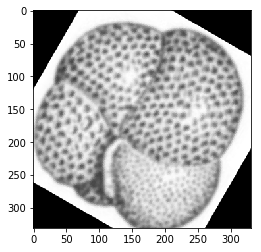

66
Morozovella


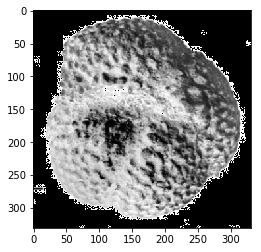

7
Globigerina


In [19]:
train_img_random = np.random.randint(0,train_images.shape[0])

plt.imshow(train_images[train_img_random])
plt.show()
#print(train_labels[train_img_random])
cl = categorical_to_cls(train_labels[train_img_random])
print(cl)
print(class_names[cl])

validation_img_random = np.random.randint(0, validation_images.shape[0])

plt.imshow(validation_images[validation_img_random])
plt.show()
#print(validation_labels[validation_img_random])
cl = categorical_to_cls(validation_labels[validation_img_random])
print(cl)
print(class_names[cl])

1947

649

[239  17  99   8  41  74  99  99  16  25   8  17   8   8  50  33  25   8
  33  25  33  33  17  25  17  25  17   8  74  17   8   8   8  25  25   8
  17  25  33   0  33  33   8   8  50   8  17   8  17   8  17  17   8   8
  16   8  16   8  17  25  17   8  25   8   8   8  33  41  17   8   8   8
  17   8   8   8   8   8   8   8]

[80  5 33  3 14 25 33 33  6  8  3  5  3  3 16 11  8  3 11  8 11 11  5  8
  5  8  5  3 25  5  3  3  3  8  8  3  5  8 11  0 11 11  3  3 16  3  5  3
  5  3  5  5  3  3  6  3  6  3  5  8  5  3  8  3  3  3 11 14  5  3  3  3
  5  3  3  3  3  3  3  3]



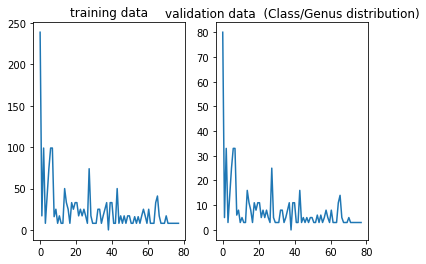

In [20]:
# Check how good is the stratification (class distribution in training and validation data)

tl = []
tlc = []
for x in train_labels:
    cl = categorical_to_cls(x)
    tlc.append(cl)
    
vl = []
vlc = []
for x in validation_labels:
    cl = categorical_to_cls(x)
    vlc.append(cl)    
    
print(len(tlc))
#print(tlc)
print("")
print(len(vlc))
#print(vlc)
print("")

bin_num = 80
th, tbin = np.histogram(tlc, bins=bin_num)
print(th)
print("")
vh, vbin = np.histogram(vlc, bins=bin_num)
print(vh)
print("")

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(tbin[0:bin_num], th)
plt.title('training data')
plt.subplot(1, 2, 2)
plt.plot(vbin[0:bin_num], vh)
plt.title('validation data  (Class/Genus distribution)')
plt.show()
    

In [21]:
print(train_images.shape)
print(validation_images.shape)
print(test_images.shape)

print(train_labels.shape)
print(validation_labels.shape)
print(test_labels.shape)

(1947, 331, 331, 3)
(649, 331, 331, 3)
(236, 331, 331, 3)
(1947, 79)
(649, 79)
(236, 79)


In [22]:
from keras import layers
from keras import models
from time import strftime, gmtime

cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
model_name='simple_convnet' + str(cur_time)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), use_bias = False, activation='relu', input_shape=(img_width, img_height, img_chan)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), use_bias = False, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), use_bias = False, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten(input_shape = (img_width, img_height, img_chan)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
model.add(layers.Dense(len(uniq_cls), activation='sigmoid'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 329, 329, 32)      864       
_________________________________________________________________
batch_normalization_1 (Batch (None, 329, 329, 32)      128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 329, 329, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 164, 164, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 162, 162, 64)      18432     
_________________________________________________________________
batch_normalization_2 (Batch (None, 162, 162, 64)      256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 162, 162, 64)      0         
__________

In [23]:
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())
model_name='vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_' + str(cur_time)
#model_name = 'convbase_vgg19_adam_epoch_200_two_fc_4096' + str(cur_time)
print(model_name)

vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38


In [24]:
cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime())

# Use pretrained modela
# Model 1

#from keras.applications import VGG16
#conv_base_vgg16 = VGG16(weights='imagenet',
#                  include_top=False,
#                  input_shape=(img_width, img_height, img_chan))

# Model 2

from keras.applications import VGG19
conv_base_vgg19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(img_width, img_height, img_chan))

# Model 3

from keras.applications import ResNet50

#conv_base_resnet50 = ResNet50(weights='imagenet',
#                  include_top=False,
#                  input_shape=(img_width, img_height, img_chan))

# Model 4
#from keras.applications import InceptionV3

#conv_base_inceptionv3 = InceptionV3(weights='imagenet',
#                  include_top=False, 
#                  input_shape=(img_width, img_height, img_chan))

# Model 5
from keras.applications import InceptionResNetV2

#conv_base_inceptionresnetv2 = InceptionResNetV2(weights = 'imagenet',
#                                               include_top=False, 
#                                               input_shape=(img_width, img_height, img_chan))

# Model 6
#from keras.applications import NASNetLarge

#conv_base_nasnet = NASNetLarge(weights = 'imagenet', 
#                                   include_top = False,
#                                 input_shape=(img_width, img_height, img_chan))

conv_base = conv_base_vgg19
#conv_base = conv_base_inceptionresnetv2
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 331, 331, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 331, 331, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 82, 82, 128)       0         
__________

In [25]:
from keras import regularizers

model = models.Sequential()
conv_base.trainable = False
model.add(conv_base)
model.add(layers.Flatten(name='flatten'))
model.add(layers.Dense(4096, activation='relu', name='fc1'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu', name='fc2'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2()))

#model.add(layers.Flatten())
#model.add(layers.Dense(512, activation='relu')) #activity_regularizer=regularizers.l1(0.01)
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2(0.05)))
model_backup = model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 10, 10, 512)       20024384  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              209719296 
_________________________________________________________________
batch_normalization_5 (Batch (None, 4096)              16384     
_________________________________________________________________
dropout_5 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
__________

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.utils import get_file
from keras import backend as K
import h5py

def VGG19_convolutions(input_shape = (331, 331, 3),
                       pooling=None,
                       classes=1000):

    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1', 
                      input_shape=input_shape))
   
    model.add(Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))
    
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))
    
    # Block 2
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))
    model.add(Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))
    model.add(Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

    # Block 5
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))
    model.add(Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv4'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

    if pooling == 'avg':
        model.add(GlobalAveragePooling2D())
    elif pooling == 'max':
        model.add(GlobalMaxPooling2D())
    
    return model

In [ ]:
VGG19_WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                             'releases/download/v0.1/'
                             'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [29]:
weights_path = get_file(
                    'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    VGG19_WEIGHTS_PATH_NO_TOP,
                    cache_subdir='models',
                    file_hash='6d6bbae143d832006294945121d1f1fc')

80142336/80134624 [==============================] - 31s 0us/step


In [30]:
model = VGG19_convolutions()

model.load_weights(weights_path)
       
model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu', name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(uniq_cls), activation='sigmoid', kernel_regularizer=regularizers.l2()))

In [31]:
#model = model_backup
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 331, 331, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 82, 82, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 82, 82, 256)       295168    
__________

In [32]:
models_dir='./models'

save_period=1
schedule = None

In [33]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, TensorBoard
from time import strftime, gmtime

cur_time = strftime("%Y-%m-%d %H:%M:%S", gmtime()) 
best_model_file = '{}/best_{}_{}.h5'.format(models_dir, model_name,cur_time)
print(best_model_file)

class ModelCheckpointMGPU(ModelCheckpoint):
    def __init__(self, original_model, filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        self.original_model = original_model
        super().__init__(filepath, monitor, verbose, save_best_only, save_weights_only, mode, period)

    def on_epoch_end(self, epoch, logs=None):
        self.model = self.original_model
        super().on_epoch_end(epoch, logs)

def freeze_model(model, freeze_before_layer):
    if freeze_before_layer == "ALL":
        for l in model.layers:
            l.trainable = False
    else:
        freeze_before_layer_index = -1
        for i, l in enumerate(model.layers):
            if l.name == freeze_before_layer:
                freeze_before_layer_index = i
        for l in model.layers[:freeze_before_layer_index + 1]:
            l.trainable = False


best_model = ModelCheckpointMGPU(model, filepath=best_model_file, monitor='val_loss',
                                     verbose=1,
                                     mode='min',
                                     period=save_period,
                                     save_best_only=True,
                                     save_weights_only=True)
last_model_file = '{}/last_{}_{}.h5'.format(models_dir, model_name,cur_time)
print(last_model_file)

last_model = ModelCheckpointMGPU(model, filepath=last_model_file, monitor='val_loss',
                                     verbose=1,
                                     mode='min',
                                     period=save_period,
                                     save_best_only=False,
                                     save_weights_only=True)

callbacks = []
callbacks.append(best_model)
callbacks.append(last_model)

tb = TensorBoard("./logs/{}".format(model_name))
callbacks.append(tb)

./models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5
./models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5


In [34]:
from keras.optimizers import Adam, RMSprop,SGD

opt_pref = 'sgd'
learning_rate = 0.01
momentum=0.9
decay = 0

if opt_pref == 'adam':
    optimizer = 'adam'
elif opt_pref == 'adam2':
    #optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, amsgrad=False)
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-10, decay=decay, amsgrad=False)
elif opt_pref == 'amsgrad':
    optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay, amsgrad=True)
elif opt_pref == 'rmsprop':
    optimizer = RMSprop(lr=learning_rate, decay = decay)
elif opt_pref == 'adamax':
    optimizer = AdaMax(lr=learning_rate, decay = decay)
elif opt_pref == 'sgd':
    optimizer = SGD(lr=learning_rate, decay=decay, momentum=momentum) #, nesterov=True)

In [35]:
epoch = 200
batch_size = 20

In [40]:
from keras.callbacks import ReduceLROnPlateau

def schedule_steps(epoch, steps):
    for step in steps:
        if step[1] > epoch:
            print("Setting learning rate to {}".format(step[0]))
            return step[0]
        print("Setting learning rate to {}".format(steps[-1][0]))
        return steps[-1][0]


steps = [(1e-6, 2), (1e-5, 10), (5e-6, 20), (3e-6, 25)]
if steps is not None:
    lrSchedule = LearningRateScheduler(lambda epoch: schedule_steps(epoch, steps))
    callbacks.insert(0, lrSchedule)

callbacks.append(lrSchedule)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=10, min_lr=0.0000001)
callbacks.append(reduce_lr)

In [41]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 331, 331, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 82, 82, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 82, 82, 256)       295168    
__________

In [ ]:
#history = model.fit(train_images, train_labels, validation_data=(validation_images, validation_labels), epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)
history = model.fit(train_images, train_labels, validation_split=0.30, epochs=epoch, batch_size=batch_size, callbacks=callbacks, verbose=1)

Train on 1362 samples, validate on 585 samples
Epoch 1/200
Setting learning rate to 1e-06
Setting learning rate to 1e-06
Setting learning rate to 1e-06
Setting learning rate to 1e-06
1362/1362 [==============================] - 44s 33ms/step - loss: 6.1912 - acc: 0.0184 - val_loss: 5.9682 - val_acc: 0.0120

Epoch 00001: val_loss improved from 5.97110 to 5.96820, saving model to ./models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5

Epoch 00001: saving model to ./models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5


/apps/gilbreth/ml/ml-toolkit/conda-5.1.0-py36/gpu/install/keras-2.2.4/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `accuracy` which is not available. Available metrics are: val_loss,val_acc,loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/200
Setting learning rate to 1e-06
Setting learning rate to 1e-06
Setting learning rate to 1e-06
Setting learning rate to 1e-06
1362/1362 [==============================] - 48s 35ms/step - loss: 6.1996 - acc: 0.0132 - val_loss: 5.9656 - val_acc: 0.0103

Epoch 00002: val_loss improved from 5.96820 to 5.96561, saving model to ./models/best_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5

Epoch 00002: saving model to ./models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5
Epoch 3/200
Setting learning rate to 3e-06
Setting learning rate to 3e-06
Setting learning rate to 3e-06
Setting learning rate to 3e-06
1362/1362 [==============================] - 48s 35ms/step - loss: 6.1939 - acc: 0.0125 - val_loss: 5.9798 - val_acc: 0.0120

Epoch 00003: val_loss did not improve from 5.96561

Epoch 00003: s

1362/1362 [==============================] - 41s 30ms/step - loss: 6.1481 - acc: 0.0154 - val_loss: 6.0004 - val_acc: 0.0068

Epoch 00017: val_loss did not improve from 5.94318

Epoch 00017: saving model to ./models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5
Epoch 18/200
Setting learning rate to 3e-06
Setting learning rate to 3e-06
Setting learning rate to 3e-06
Setting learning rate to 3e-06
1362/1362 [==============================] - 41s 30ms/step - loss: 6.1805 - acc: 0.0184 - val_loss: 5.9540 - val_acc: 0.0068

Epoch 00018: val_loss did not improve from 5.94318

Epoch 00018: saving model to ./models/last_vgg19_extended_sgd_momemtum_0.9_decay_0_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 20:03:38_2019-03-28 20:40:48.h5
Epoch 19/200
Setting learning rate to 3e-06
Setting learning rate to 3e-06
Setting learning rate to 3e-06
Setting learning rate to 3e-06
1362

In [ ]:
# """
# Plotting multiple scalars on the same graph
# """
# from numpy import random
    
# writer_val = tf.summary.FileWriter("./logs/{}/plot_val".format(model_name))
# writer_train = tf.summary.FileWriter("./logs/{}/plot_train".format(model_name))
# loss_var = tf.Variable(0.0)
# tf.summary.scalar("loss", loss_var)
# write_op = tf.summary.merge_all()
# session = tf.InteractiveSession()
# session.run(tf.global_variables_initializer())
# for i in range(100):
#  # loss validation
#  summary = session.run(write_op, {loss_var: random.rand()})
#  writer_val.add_summary(summary, i)
#  writer_val.flush()
#  # loss train
#  summary = session.run(write_op, {loss_var: random.rand()})
#  writer_train.add_summary(summary, i)
#  writer_train.flush()

In [58]:
best_model_file = './models/' + 'best_vgg19_extended_adam_epoch_200_two_fc_40962019-03-21 22:03:02_2019-03-21 22:04:46.h5'
last_model_file = './models/' + 'last_vgg19_extended_adam_epoch_200_two_fc_40962019-03-21 22:03:02_2019-03-21 22:04:46.h5'

#best_model_file = './models/best_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 13:14:53_2019-03-28 13:15:37.h5'
#last_model_file = './models/last_vgg19_extended_adam_epoch_200_two_fc_4096_lr_0.01_no_reduce_lr_callback_time_2019-03-28 13:14:53_2019-03-28 13:15:37.h5'

In [59]:
# last model
# last_convbase_vgg19_img_dim_331_kernel_regularizer2018-10-28 02:20:00_2018-10-28 03:53:16.h5
model.load_weights(last_model_file)
res_last = model.evaluate(test_images, test_labels)
print(res_last)

# best model
# ./models/best_convbase_vgg19_img_dim_331_kernel_regularizer2018-10-28 02:20:00_2018-10-28 03:53:16.h5

model.load_weights(best_model_file)

res_best = model.evaluate(test_images, test_labels)
print(res_best)

236/236 [==============================] - 1s 5ms/step
[1.7743610305301214, 0.8813559311931416]
236/236 [==============================] - 1s 5ms/step
[1.7285740698798229, 0.8983050847457628]


In [41]:
model.evaluate(test_images, test_labels)

236/236 [==============================] - 1s 5ms/step


[1.2225541179463015, 0.9152542372881356]

In [42]:
pred = model.predict(test_images, verbose=1)

236/236 [==============================] - 2s 6ms/step


In [43]:
n = pred.shape[1]
print(n)
pred_cls_identity = np.eye(n)
idx = np.argmax(pred, axis=1)

# creating the predicted class from identity matrix
pred_cls = pred_cls_identity[idx]
print(pred_cls.shape)

79
(236, 79)


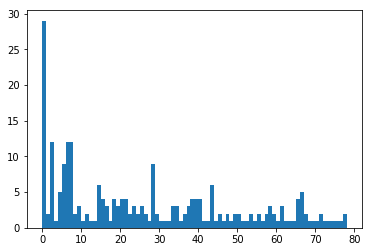

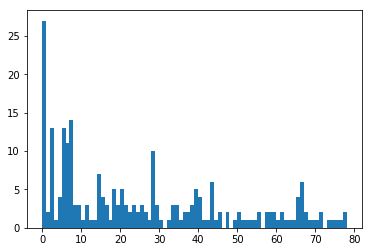

In [44]:
# Show the true and predicted class distribution

true_clss = [categorical_to_cls(tc) for tc in test_labels]
plt.hist(true_clss, bins=78)
plt.show()

pred_clss = [categorical_to_cls(pc) for pc in pred_cls]
plt.hist(pred_clss, bins = 78)
plt.show()

In [45]:
# calculating accuracy

total_n = test_labels.shape[0]
pred_acc_t = [np.sum(test_labels[i] == pred_cls[i]) == n for i in np.arange(total_n)]
pred_acc_ix = [i for i in np.arange(total_n) if np.sum(test_labels[i] == pred_cls[i]) == n]
pred_err_t = [np.sum(test_labels[i] == pred_cls[i]) != n for i in np.arange(total_n)]
pred_err_ix = [i for i in np.arange(total_n) if np.sum(test_labels[i] == pred_cls[i]) != n]
pred_acc = np.sum(pred_acc_t)/total_n
pred_err = np.sum(pred_err_t)/total_n
print(pred_acc)
print(pred_err)

0.9152542372881356
0.0847457627118644


20
true class = 14
true class name = Morozovella
predicted class = 0
predicted class name = Globorotalia


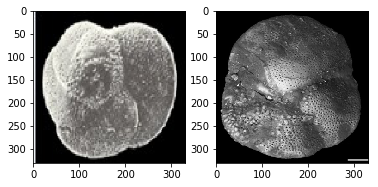

true class = 16
true class name = Praemurica
predicted class = 1
predicted class name = Hedbergella


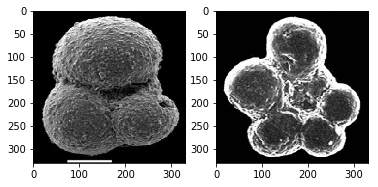

true class = 31
true class name = Whiteinella
predicted class = 2
predicted class name = Globigerinoides


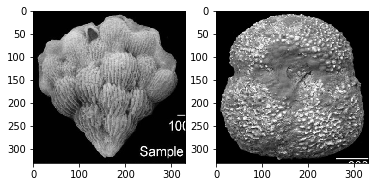

true class = 6
true class name = Globoturborotalita
predicted class = 3
predicted class name = Cribrohantkenina


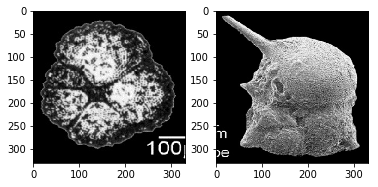

true class = 46
true class name = Hantkenina
predicted class = 0
predicted class name = Globorotalia


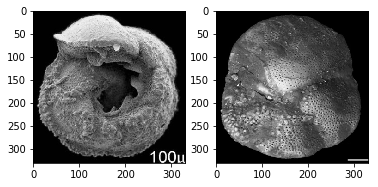

true class = 48
true class name = Helvetoglobotruncana
predicted class = 0
predicted class name = Globorotalia


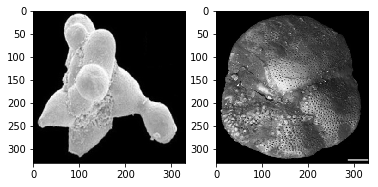

true class = 49
true class name = Planoglobulina
predicted class = 4
predicted class name = Globorotalia


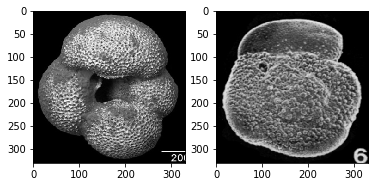

true class = 21
true class name = Globotruncana
predicted class = 5
predicted class name = Globorotalia


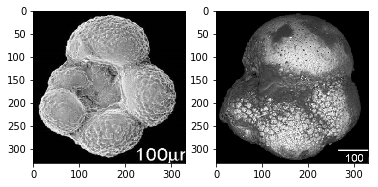

true class = 53
true class name = Globigerina
predicted class = 6
predicted class name = Globoturborotalita


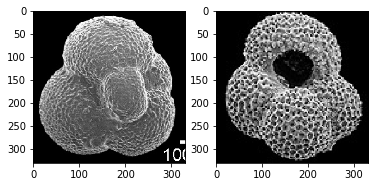

true class = 56
true class name = Globigerinelloides
predicted class = 7
predicted class name = Globigerina


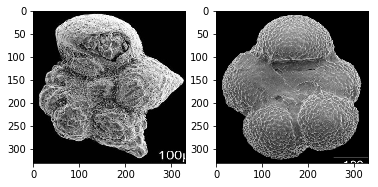

true class = 28
true class name = Pseudohastigerina
predicted class = 8
predicted class name = Morozovella


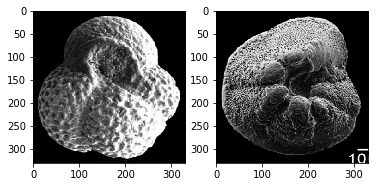

true class = 4
true class name = Globorotalia
predicted class = 2
predicted class name = Globigerinoides


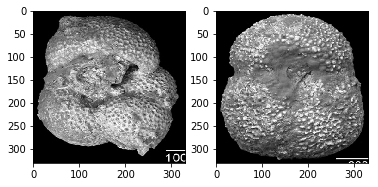

true class = 0
true class name = Globorotalia
predicted class = 9
predicted class name = Acarinina


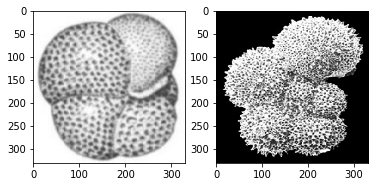

true class = 61
true class name = Morozovella
predicted class = 10
predicted class name = Thalmanninella


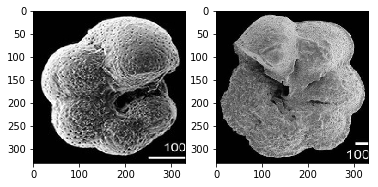

true class = 72
true class name = Paragloborotalia
predicted class = 6
predicted class name = Globoturborotalita


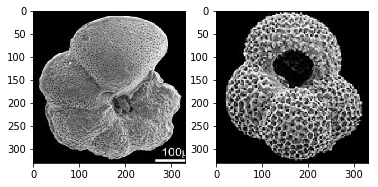

true class = 58
true class name = Globigerinatheka
predicted class = 0
predicted class name = Globorotalia


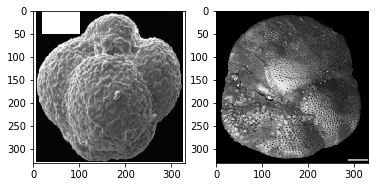

true class = 0
true class name = Globorotalia
predicted class = 11
predicted class name = Globigerinoides


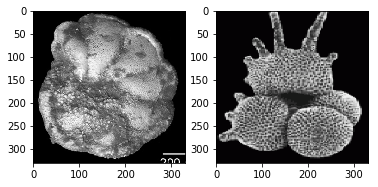

true class = 38
true class name = Praeorbulina
predicted class = 12
predicted class name = Tenuitella


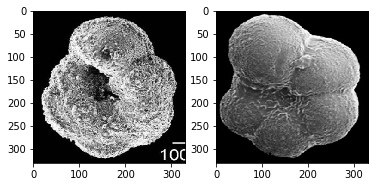

true class = 2
true class name = Globigerinoides
predicted class = 13
predicted class name = Sigalia


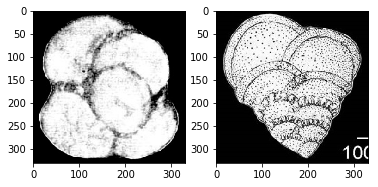

true class = 37
true class name = Acarinina
predicted class = 14
predicted class name = Morozovella


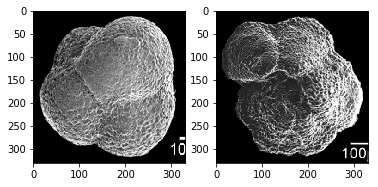

In [46]:
# Errored images/classes

err_cls = []
err_cls_names = []

print(len(pred_err_ix))
for i, err_img_ix in enumerate(pred_err_ix):
    #true
    plt.subplot(1,2, 1)
    plt.imshow(test_images[err_img_ix])
    cl = categorical_to_cls(test_labels[err_img_ix])
    print("true class = " + str(cl))
    print("true class name = " + str(class_names[cl]))
    err_cls.append(cl)
    err_cls_names.append(class_names[cl])
    
    #predicted
    pcl = categorical_to_cls(pred_cls[i])
    plt.subplot(1,2, 2)
    plt.imshow(test_images[pcl])
    print("predicted class = " + str(pcl))
    print("predicted class name = " + str(class_names[pcl]))
    
    plt.show()

In [47]:
# which are the erred classes
err_cls_s = set(err_cls)
np.array(err_cls_s)
print(len(err_cls_s))
print(236-len(err_cls_s))

19
217


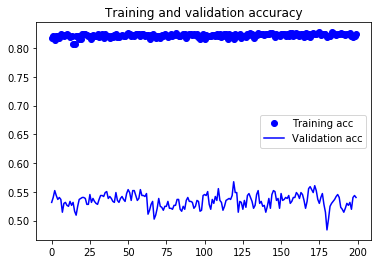

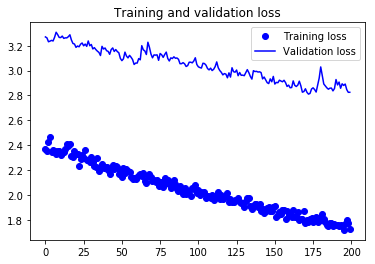

In [48]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
!echo $path
!ls $path

/scratch/gilbreth/azehady/automatic_fossil_image_detection/datapack_images/Global/Foram_TSCLite_Images
Abathomphalus intermedius tiny.jpg
Abathomphalus intermedius.JPG
Abathomphalus mayaroensis tiny.jpg
Abathomphalus mayaroensis.JPG
Acarinina acarinata tiny.jpg
Acarinina acarinata.jpg
Acarinina bullbrooki tiny.jpg
Acarinina bullbrooki.jpg
Acarinina collactea tiny.jpg
Acarinina collactea.jpg
Acarinina cuneicamerata tiny.jpg
Acarinina cuneicamerata.jpg
Acarinina mcgowrani tiny.jpg
Acarinina mcgowrani.jpg
Acarinina mckannai tiny.jpg
Acarinina mckannai.jpg
Acarinina pentacamerata tiny.jpg
Acarinina pentacamerata.jpg
Acarinina primitiva tiny.jpg
Acarinina primitiva.jpg
Acarinina sibaiyaensis tiny.jpg
Acarinina sibaiyaensis.jpg
Acarinina soldadoensis tiny.jpg
Acarinina soldadoensis.jpg
Acarinina strabocella tiny.jpg
Acarinina strabocella.jpg
Acarinina subsphaerica tiny.jpg
Acarinina subsphaerica.jpg
Archaeoglobigerina bosquensis tiny.jpg
Archaeoglobigerina bosquensis.jpg
Astrorotalia palmera

In [50]:
# load the new test image files (unseen classes)
import copy
path = './datapack_images/Global/Foram_New_Test_Images'

new_test_file_names = None
for (dirpath, dirnames, fnames) in walk(path):
    new_test_file_names = fnames

new_test_image_files = []
new_genus_single = []

for f in new_test_file_names:
    forig = copy.copy(f)
    new_test_image_files.append(forig)

    if ' ' in f:
        f = f.split(' ')
        new_genus_single.append(f[0])
        
for i, f in enumerate(new_test_image_files):
    print(f)
    print(new_genus_single[i])
    
#print(len(genus_single))
#print(genus_multiple)

Hantkenina alabamensis.png
Hantkenina
Globigerina archaeobulloides 2.png
Globigerina
Globorotalia puncticulata.png
Globorotalia
Acarinina pseudosubsphaerica.png
Acarinina
Morozovella caucasica.png
Morozovella
Acarinina aspensis.png
Acarinina
Globigerinoides obliquus.png
Globigerinoides
Acarinina medizzai.png
Acarinina
Morozovella marginodentata.png
Morozovella
Acarinina interposita.png
Acarinina
Globigerina officinalis.png
Globigerina
Acarinina altoconica.png
Acarinina
Globigerinoides conglobatus.png
Globigerinoides
Globigerinoides seigliei.png
Globigerinoides
Orbulina universa.png
Orbulina
Acarinina echinata.png
Acarinina
Globigerinoides altiapertura.png
Globigerinoides
Globigerina bulloides.png
Globigerina
Globigerina falcoensis.png
Globigerina
Globigerinoides italicus.png
Globigerinoides
Globoconella terminalis.png
Globoconella
Hantkenina australis.png
Hantkenina
Globorotalia miozea.png
Globorotalia
Globigerinella siphonifera.png
Globigerinella
Sphaeroidinella dehiscens.png
Sphaeroi

In [51]:
# Load image data from file
# And augment images
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
import cv2 as cv

img_width = 331 #128 * 2 * 2
img_height = 331 #128 * 2 * 2
img_chan = 3

#plt.figure(figsize=(20,10))
new_test_imgs = []
new_test_lbls = []
for j, fname in enumerate(new_test_image_files):
    img = load_img(path + '/' + fname)
    
    # converting to numpy array
    imga = np.array(img)
    
    # reshaping to same size using the power of cv
    imgr = cv.resize(imga, (img_width, img_height), interpolation=cv.INTER_AREA)
    #print(imgr.shape)
    new_test_imgs.append(imgr)
    clas = final_cls[new_genus_single[j]]
    new_test_lbls.append(clas)
    
    #plt.subplot((j%10) + 1,len(file_names), (j%10) + 1)
    print(j)
    print(fname)
    print(new_genus_single[j])
    print(clas)
    print("")
    #plt.imshow(train_imgs[j])

    #plt.show()



0
Hantkenina alabamensis.png
Hantkenina
29

1
Globigerina archaeobulloides 2.png
Globigerina
5

2
Globorotalia puncticulata.png
Globorotalia
0

3
Acarinina pseudosubsphaerica.png
Acarinina
7

4
Morozovella caucasica.png
Morozovella
6

5
Acarinina aspensis.png
Acarinina
7

6
Globigerinoides obliquus.png
Globigerinoides
2

7
Acarinina medizzai.png
Acarinina
7

8
Morozovella marginodentata.png
Morozovella
6

9
Acarinina interposita.png
Acarinina
7

10
Globigerina officinalis.png
Globigerina
5

11
Acarinina altoconica.png
Acarinina
7

12
Globigerinoides conglobatus.png
Globigerinoides
2

13
Globigerinoides seigliei.png
Globigerinoides
2

14
Orbulina universa.png
Orbulina
69

15
Acarinina echinata.png
Acarinina
7

16
Globigerinoides altiapertura.png
Globigerinoides
2

17
Globigerina bulloides.png
Globigerina
5

18
Globigerina falcoensis.png
Globigerina
5

19
Globigerinoides italicus.png
Globigerinoides
2

20
Globoconella terminalis.png
Globoconella
57

21
Hantkenina australis.png
Hantkenina

In [52]:
np.argwhere(train_labels[0])

array([[51]])

In [53]:
# get the main training image data
new_test_images = np.array(new_test_imgs)
# For Dense layers
#new_test_images = new_test_images.reshape(len(new_test_images), img_width * img_height * img_chan)
# For CNN
new_test_images = new_test_images.reshape(len(new_test_images), img_width, img_height, img_chan)
new_test_images = new_test_images.astype('float32') / 255

# convert into categorical y label
new_test_labels = np.zeros((len(new_test_lbls),len(uniq_cls)))
for i, li in enumerate(new_test_lbls):
    new_test_labels[i, li] = 1


In [56]:
print(new_test_images.shape)
print(new_test_labels.shape)

(37, 331, 331, 3)
(37, 79)


In [60]:
model.evaluate(new_test_images, new_test_labels)

37/37 [==============================] - 0s 5ms/step


[3.862764951345083, 0.4324324332379006]